In [1]:
from IPython.core.display import HTML
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
import numpy
#
import math
#
import scipy
from scipy import constants
#
import matplotlib.pyplot 
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
#
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
#
from JSAnimation import IPython_display
from moviepy.editor import *
# 
import timeit
import numba
from numba import jit

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [3]:
def plot(v1, v2, xlabl, ylabl, title):
    #
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    #
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)
    #
    pyplot.tick_params(axis='x', pad=10, labelbottom='off')
    pyplot.tick_params(axis='y', pad=10)
    #
    pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
    #
    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

### Domain

In [4]:
def get_domain(Ld, n_gap):
    ''' This function obtains the domain based on a 
    staggered grid. The domain is divided into three parts:
    (1) anode region, (2) gap, (3) cathode.
    
    Parameters:
    ----------
    Ld: Domain Length
    n_gap: number of boundary nodes in gap
    
    Returns:
    --------
    '''
    #staggered grid approach
    #gap region
    xl_gap = 0.0
    xr_gap = Ld
    delx_gap = (xr_gap-xl_gap)/(n_gap-1.0)
    xb_gap = numpy.linspace(xl_gap, xr_gap, n_gap)
    xc_gap = xb_gap[:-1]+(delx_gap*0.5)
    #
    #
    return delx_gap, xb_gap, xc_gap
    

In [5]:
# Domain, Dimensions
L_chamber = 0.24  #meters
Lgap = 0.004 #interelectrode gap [meters]
L_cathode = 0.112
L_anode = L_chamber - (Lgap + L_cathode)
#
nx_anode = 101
nx_cathode = 111
nx_gap = 121
#
Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]

#get cell boundary and cell center locations
dx, xb, xc = get_domain(Lgap,nx_gap)
#
l2_target = 1e-7
#
#time step
dt = 1e-6 #0.000015 # {sec} time step

In [6]:
numpy.shape(xb)

(121,)

In [7]:
numpy.shape(xc)

(120,)

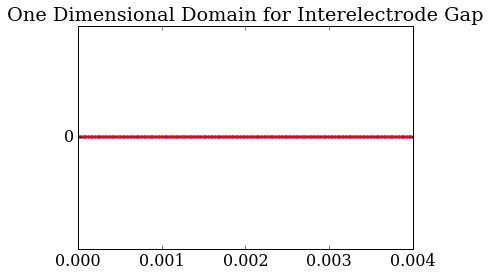

In [8]:
Xc_gap = numpy.meshgrid(xc)
Xb_gap = numpy.meshgrid(xb)
#
pyplot.title('One Dimensional Domain for Interelectrode Gap')
pyplot.ylim(-.0002,0.0002)
pyplot.xlim(0., Lgap)
pyplot.scatter(Xb_gap,numpy.zeros_like(Xb_gap),\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(Xc_gap,numpy.zeros_like(Xc_gap), \
                   s=10, color='r', marker='o', linewidth=0)
pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
pyplot.yticks(numpy.arange(0, 0.0002, 0.001));

Note that velocities are calculated on the cell boundaries (blue), and the pressure, density,electrical conductivity, potential, current density and temperature are calculated on the cell center (red)

### Initialization

In [9]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence
    
    This function is used for convergence of the pressure equation

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    
    '''
    return numpy.sqrt(numpy.sum((p_new[:] - p_old[:])**2)\
                      /numpy.sum(p_old[:]**2))

In [10]:
#Input Current
I_arc = 10.0

#Initialization Variables
gamma1 = 5.0/3.0
gravity = 9.81

# collision radius Carbon-Helium:
cr_C_He = (1.7 + 1.4)

#Constants
Ckb = scipy.constants.k  #Boltzmann Constant J/K
Cme = scipy.constants.m_e #Elementary Electron Mass kg
Ch = scipy.constants.h; # Planck's constant Js
CA = 1.2e6 #constant in electron current density eqn [A/(m^2 K^2)], pg.62
CNA = scipy.constants.N_A #avogadros number
Ce = scipy.constants.e #elementary charge, C

#Carbon
M_C = 12.0e-3/CNA #kg, mass of 1 atom of pure carbon (also = Ckb/M_C)
mC = 12.0107 # molar mass g/mol
Ips1 = 1086.5e3/CNA #J, energy of first ionization
anode_workfunction = 4.81 #eV
emissivity=0.70 #carbon, graphite
E_C = 11.2603*constants.e #ionization energy for carbon in Joules
R_C = 8314.0/mC #specific gas constant
cp_C = 2100.

#heat of vaporization anode:
dH_C = 710.0e6/mC #(710./(0.012))*1000. #
dH2_C = 355.8e6/mC #(355.8/(0.012))*1000. #convert kJ/Kmol to J/kg #

#Helium
M_He = 4.0e-3/CNA # kg, mass of 1 atom of Helium
mHe = 4.002602 #molar mass, g/mol
Ipg1 = 2372.3e3/CNA; # J, energy of first ionization
R_He = 8314.0/mHe #specific gas constant
#       

##### Initial Conditions

In [11]:
def get_initial_conditions(x1,x2,I_input,R_anode):
    '''
    Defines initial variables 
    add two ghost cells to represent nodes on anode and cathode
    
    Parameters:
    -----------
    x1: boundary x locations
    x2: center cell x locations
    I_input: arc current input
    R_anode: anode radius
    
    Returns:
    -------
    jx:current density
    phi_x: electric potential
    cp_x: specific heat
    Tx: Temperature
    e_cond: electrical conductivity
    visc: viscosity
    k_cond: thermal conductivty
    ne_x: number density of electrons
    
    Assume vent conditions and that only anode is modeled
    '''
    Tref = 300.0
    #
    a = numpy.size(x1) + 2 #this is to add ghost cells, these are boundary cells
    b = numpy.size(x2) + 2 #this is to add ghost cells, these are center cells
    #------------------------------------------
    #grid 1 (cell edges)
    ux = numpy.zeros((a),dtype=float) #velocity
    #grid 2 cell centers-----------------------
    jx = numpy.zeros((b), dtype=float) #current density
    phix = numpy.zeros((b),dtype=float) #electric potential
    econdx = numpy.zeros((b),dtype=float) #electrical conductivity
    rhox = numpy.zeros((b),dtype=float) #density
    nex = numpy.zeros((b), dtype=float) #number density of electrons
    #
    cpx = numpy.zeros((b),dtype=float) #specific heat
    Tx = numpy.zeros((b),dtype=float) #temperature
    visc = numpy.zeros((b),dtype=float) #viscosity
    kx = numpy.zeros((b),dtype=float) #thermal conductivity
    Px = numpy.zeros((b),dtype=float) # pressure
    hx = numpy.zeros((b),dtype=float) #enthalpy
    #
    Rs = numpy.zeros((b),dtype=float) # specific gas constant
    Rs[:] = 8314.0/mHe
    # 
    jx[:] = I_input/(numpy.pi*(R_anode**2)) #current density 
    # electric potential
    phix[:] = 0.0
    # specific heat
    cpx[1:] = 5195. #J/(kg-K) of helium
    cpx[0] = 5195.#cp_C #J/(kg-K) of carbon
    # temperature
    Tx[:] = Tref #kelvin # assume uniform temperature
    # viscosity
    visc[0] = 10. #Pa·s = kg/(s·m)
    visc[1:] = 19.0e-6
    # velocity, assume still
    ux[:] = 0. # m/s
    # thermal conductivity
    kx[1:] = 0.15 # W/(m-K)
    kx[0] = 110.
    # electrical conductivity
    econdx[:] = I_input # Siemens/meter
    # number density of electrons
    nex[:] = 1e6 # 1/m3, number density of electrons
    # density
    rhox[0] = 0.164#2266 #graphite kg/m3
    rhox[1:] = 0.164 #helium
    #
    Px[:] = (rhox[:])*Rs[:]*Tx[:] + (nex[:])*Ckb*Tx[:]
    #
    return Tx, jx, phix, cpx,visc, ux, kx, rhox, Px, hx, econdx, nex

In [12]:
T0,j0,phi0,cp0,mu0,u0,\
k0,rho0,p0,h0,econd0,ne0 = get_initial_conditions(xb,xc,I_arc,Ran)

In [13]:
cp0[:10]

array([ 5195.,  5195.,  5195.,  5195.,  5195.,  5195.,  5195.,  5195.,
        5195.,  5195.])

In [14]:
econd0[:10] 
# this is how the electrical conductivity is initialized (same as arc current)

array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.])

In [15]:
j0[:10] 
#this is the initial condition for current density (corresponfs to 60 amps everywhere)

array([ 315764.0386224,  315764.0386224,  315764.0386224,  315764.0386224,
        315764.0386224,  315764.0386224,  315764.0386224,  315764.0386224,
        315764.0386224,  315764.0386224])

In [16]:
h0[:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [17]:
rho0[:10]

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164])

In [18]:
T0[:10]

array([ 300.,  300.,  300.,  300.,  300.,  300.,  300.,  300.,  300.,  300.])

In [19]:
p0[:10]

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305])

## these values correspond to time n = 0

##### reference values

In [20]:
# reference values are stored (n-1) time step,
# because they are used in the energy equation
numx = numpy.size(p0)
pref = p0.copy()
Tref = T0.copy()

##### potential algorithm

In [21]:
def potential_algorithm(current_density,electrical_conductivity,electric_potential,\
                        center_nodes, delx):
    ''' Defines the field electric potential
    '''
    jx = current_density.copy()
    #
    xc_nodes = center_nodes.copy()
    x_an = xc_nodes[0] - 0.5*delx
    x_cath = xc_nodes[-1] + 0.5*delx
    #
    array_size = electrical_conductivity.size
    eratio = numpy.zeros_like(center_nodes)
    #
    A = numpy.zeros_like(electrical_conductivity)
    B = numpy.zeros_like(electrical_conductivity)
    #
    C1 = numpy.zeros_like(electrical_conductivity)
    C2 = numpy.zeros_like(electrical_conductivity)
    #
    econdx = electrical_conductivity.copy()
    phix = electric_potential.copy()
    #
    jx_anode = I_arc/(numpy.pi*(Ran**2)) 
    econdx_anode = 1e5 #electrical conductivity of carbon
    anode_potential = jx_anode*delx/econdx_anode
    #
    cathode_potential =  -1.
    #
    A[1:-1] =  - econdx[1:-1]
    B[1:-1] = - (0.5/delx)*(econdx[2:] - econdx[:-2])
    #
    for i in range(1,array_size-1):
        if (B[i]**2 == 0.0 ):
            # general solution constants
            C2[i] = (cathode_potential/(numpy.exp((-B[i]/A[i])*x_cath)) -\
                     anode_potential)/(x_cath-x_an)
            C1[i] = (anode_potential/(numpy.exp((-B[i]/A[i])*x_an))) -\
                     anode_potential
            # potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) +\
                      C2[i]*xc_nodes[i-1]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1])
        if (B[i]**2 > 0.0):
            #print('using {B**2 > 0} solution for potential')
            eratio[:] = numpy.exp((-B[i]/A[i])*x_cath)/numpy.exp((-B[i]/A[i])*x_an)
            C2[i] = (cathode_potential - anode_potential*eratio[i-1])/(1.-eratio[i-1])
            C1[i] = (anode_potential-C2[i])/numpy.exp((-B[i]/A[i])*x_an)
            #potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) + C2[i]
    #
    phix[0] = jx_anode*delx/econdx_anode
    phix[-1] = cathode_potential
    #
    return phix

In [22]:
phi_init=  potential_algorithm(j0.copy(),econd0.copy(), phi0.copy(), xc.copy(), dx)

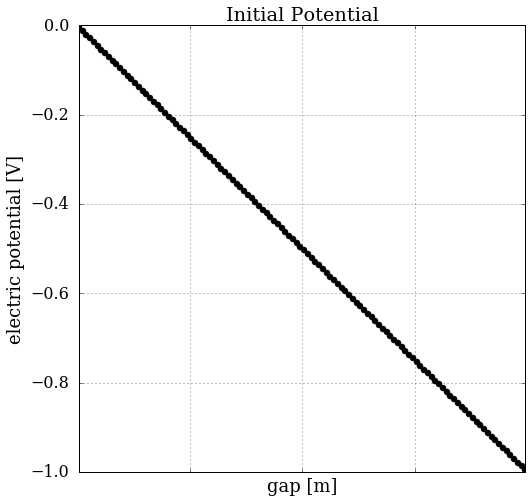

In [23]:
plot(xc, phi_init[1:-1], 'gap [m]', 'electric potential [V]', 'Initial Potential')

##### Get Temperature after Initializing Arc

## all of these values below correspond to time n = 1, until we reach then next energy function

In [24]:
def get_energy_initial(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
              enthalpy, reference_temperature):
    ''' Defines energy based on computed values, 
    includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    
    Note that this actually solves for (rho*h)
    
    h = (rho*h)\rho
    
    T^{n+1} = h/cp + T_{ref}
    '''
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = numpy.zeros_like(enthalpy) #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy()
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econd = electrical_conductivity.copy()
    jx = current_density.copy()
    # joule heating flux
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econd[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - dTemp[:-2])
    # conductive heat flux
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    # pressure flux
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-Px[:-2])*ux_int[1:-1]
    # convective heat flux, or momentum flux
    Mflux[1:-1] = - (0.5*delt/delx)*\
                  (rhox[2:]*ux_int[2:]*hx[2:] -rhox[:-2]*ux_int[:-2]*hx[:-2])
    # for time n+1, so rhoh_{n+1}
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    h_new[0] = h_new[1]
    h_new[-1] = h_new[-2]
    #
    T_new[1:-1] = ((h_new[1:-1]-hx[1:-1])/cpx[1:-1]) + T_ref[1:-1]
    #
    #boundary conditions    
    phi_C_eV = 4.81
    Uiz = 11.2603 # ionization energy carbon eV
    # anode region
    Tev_an = T_new[1]/(11604.52500617)
    jth = 0.25*Ce*(ne0[1])*(numpy.sqrt((8*Ce*Tev_an)/(numpy.pi*Cme)))
    # Anode Sheath drop:
    Ua_eV = - Tev_an*numpy.log(jth/numpy.abs(jx[0]))
    qa = jx[0]*(2*Tev_an+ phi_C_eV + Ua_eV) #- dH2_C
    #cathode region
    Tev_cath = T_new[-2]/(11604.52500617)
    je = CA*(Tev_cath**2)*numpy.exp(-phi_C_eV /(Ckb*Tev_cath)) 
    qc = jx[-1]*(Uiz + phi_C_eV) - je*phi_C_eV
    #
    k_carbon = 10. ##(W/m K)
    k_helium = 0.15 + (10.0-0.15)*(T_new[-2]-Tref[-2])/20000.0 
    T_new[0] = T_new[1] + (qa*delx)/k_carbon
    T_new[-1] = T_new[-2] #+ (qc*delx)/k_helium
   
    #
    return T_new
    

In [25]:
Tn = get_energy_initial(rho0.copy(), p0.copy(), u0.copy(), j0.copy(), k0.copy(),\
               econd0.copy(), cp0.copy(), dx, dt, pref.copy(),\
              h0.copy(), Tref.copy())


In [26]:
Tn # this is the temperature {K} at the next time step t = 0 

array([ 317.72430127,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296581,
        311.70296581,  311.70296581,  311.70296581,  311.70296

In [27]:
Tref2 = Tn.copy()
# href2 = hn.copy()

#### This is the temperature distribution used to initialize. Note that this will vary depending on the time step

##### Thermophysical Properties

In [28]:
def get_thermophysical_properties(temperature):
    ''' finds viscosity, thermal conductivity
    '''
    mu = numpy.zeros_like(temperature) #viscosity
    kth = numpy.zeros_like(temperature) #thermal conductivity
    T = temperature.copy() # temperature
    a = numpy.size(T)
    #
    kth[:] = 0.15 + (10.0-0.15)*(T[:]-300.0)/20000.0
    #
    for i in range(a):
        #
        if (T[i]<1873.0):
            mu[i] = -1.4083e-11*T[i]*T[i] + 5.2322e-8*T[i] + 5.4399e-6
        else:
            mu[i] = 5.4e-5
        #
        if(kth[i]>10.0):
            kth[i] = 10.0
        #
    return kth, mu

In [29]:
kn, mun = get_thermophysical_properties(Tn.copy())

In [30]:
kn[:10]

array([ 0.15872922,  0.15576371,  0.15576371,  0.15576371,  0.15576371,
        0.15576371,  0.15576371,  0.15576371,  0.15576371,  0.15576371])

In [31]:
mun[:10]

array([  2.06422099e-05,   2.03805361e-05,   2.03805361e-05,
         2.03805361e-05,   2.03805361e-05,   2.03805361e-05,
         2.03805361e-05,   2.03805361e-05,   2.03805361e-05,
         2.03805361e-05])

##### Ablation of Anode

In [32]:
def get_ablation(anode_temperature, molecular_weight):
    '''Defines ablation rate
    
    in { kg } / { m2 s }
    '''
    Tan = anode_temperature
    A = 15.73
    B = 40030.0
    #
    MW = molecular_weight
    #
    p_vapor = (0.133*numpy.exp(2.3*(A - B/Tan)))
    ablation = p_vapor*numpy.sqrt(MW/(2*numpy.pi*Ckb*Tan))
    rho_vapor = p_vapor/(R_C*Tan)
    #
    return ablation, rho_vapor

In [33]:
ABL, rhov = get_ablation(Tn[0],M_C)

In [34]:
rhov # vapor density in { kg } / { m3 }

4.4219499500134517e-117

In [35]:
ABL # ablation rate in { kg } / { m2 s }

8.2692162375203286e-115

##### update density boundary conditions to include the ablated density

In [36]:
def get_initial_concentrations(density, ablated_density):
    ''' defines initial concentrations
    '''
    rhox = density.copy()
    #
    c_C = numpy.zeros_like(density)
    c_He = numpy.zeros_like(density)
    #Concentration of carbon
    c_C[:] = ablated_density/(rhox[:])
    c_C[0] = 1.0
    # concentration of helium
    c_He[:] = (rhox[:]-ablated_density)/rhox[:]
    c_He[0] = 1e-14

    #
    return c_C, c_He

In [37]:
def density_bc(density, ablated_density):
    ''' updates densities in the anode region 
    by summing ablated density with local density
    '''
    rhobc = density.copy()
    local_density = rhobc[1]
    #
    rhobc[-1] = rhobc[-2]
    #
    if (ablated_density<local_density):
        rhobc[0] = ablated_density+local_density
    else:
        rhobc[0] = ablated_density
    #
    return rhobc

In [38]:
rhon = density_bc(rho0.copy(), rhov)
rhon[:10]

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164])

In [39]:
cs1, cg1 = get_initial_concentrations(rhon, rhov)

In [40]:
cs1[:10]

array([  1.00000000e+000,   2.69631095e-116,   2.69631095e-116,
         2.69631095e-116,   2.69631095e-116,   2.69631095e-116,
         2.69631095e-116,   2.69631095e-116,   2.69631095e-116,
         2.69631095e-116])

In [41]:
cg1[:10]

array([  1.00000000e-14,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00])

##### obtain velocity of sublimated particles

In [42]:
def get_ablation_velocity(ablation_rate, density, ablated_density):
    '''obtains the velocity of sublimated particles
    '''
    rhox = density.copy()
    abl_rate = ablation_rate
    #
    ablation_velocity = (abl_rate)/(rhox[1]+ablated_density)
    #
    return ablation_velocity

In [43]:
u_abl = get_ablation_velocity(ABL, rhon.copy(), rhov)
u_abl #m/s

5.0422050228782487e-114

## Depending on the initial temperature, there may be no sublimation of the anode material

##### Solve Momentum Equation

In [44]:
def initial_velocity(velocity,ablation_velocity):
    ''' defines initial velocity in the field
    
    Boundary_conditions:
    --------------------
    Ghost cell and anode/fluid interface velocities are set,
    as the sublimation velocity
    
    '''
    ui = velocity.copy()
    ui[0] = ablation_velocity
    ui[1] = ablation_velocity
    #
    return ui

In [45]:
u_init = initial_velocity(u0.copy(), u_abl)
u_init[:5] #the rest are zeros initially

array([  5.04220502e-114,   5.04220502e-114,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000])

### The velocity of sublimated particles is a function of temperature, so depending on the initial temperature, there may be no sublimation

### Now,  solve momentum equation to obtain velocity distribution and heavy particle pressure (i.e., exclude electrons). Here I use the fractional step method to solve for the heavy particle pressure and the velocity field.

In [46]:
def convective_flux(velocity, delx):
    ''' calculates convective fluxes for momentum equation
    '''
    ux = velocity.copy()
    fc = numpy.zeros_like(velocity)
    #
    fc[1:-1] = (-0.5/delx)*((ux[2:]**2)-(ux[:-2]**2) )
    #
    return fc

In [47]:
fct = convective_flux(u_init.copy(), dx)
fct[:5]

array([  0.00000000e+000,   3.81357472e-223,   3.81357472e-223,
        -0.00000000e+000,  -0.00000000e+000])

In [48]:
def viscous_flux(velocity, delx, shear_viscosity, density):
    ''' calculates viscous fluxes for momentum equation
    '''
    ux = velocity.copy()
    fv = numpy.zeros_like(velocity)
    fv2 = numpy.zeros_like(velocity) # = mu * d/dx {u}
    #
    mux = shear_viscosity.copy()
    muxb = numpy.zeros_like(velocity) #interpolated viscosity boundary values
    muxb[1:-1] = 0.5*(mux[1:]+mux[:-1])
    #
    rhox = density.copy() #density at cell center
    #
    rhoxb = numpy.zeros_like(velocity) #density at cell boundary
    #
    #interpolate densities to cell boundaries
    #anode
    rhoxb[0] = rhox[0]
    rhoxb[1] = rhox[0] 
    # inner points
    rhoxb[2:-1] = 0.5*(rhox[2:]+rhox[1:-1])
    #exit
    rhoxb[-1] = rhoxb[-2]
    #
    fv[1:-1] = (muxb[1:-1]/rhoxb[1:-1])*(1/(delx**2))*\
                (ux[2:] - 2*ux[1:-1] + ux[:-2])
    #
    return fv

In [49]:
fvt= viscous_flux(u_init.copy(), dx, mun.copy(), rhon.copy())

In [50]:
fvt[:5]

array([  0.00000000e+000,  -5.67562763e-109,   5.63942422e-109,
         0.00000000e+000,   0.00000000e+000])

In [51]:
def pressure_flux(velocity, pressure, delx):
    ''' calculates pressure fluxes for momentum equation
    '''
    px = pressure.copy()
    #
    fp = numpy.zeros_like(velocity)
    #
    fp[1:-1] = -(1./delx)*(px[1:]-px[:-1])
    #
    return fp

In [52]:
fpt = pressure_flux(u_init.copy(), p0.copy(), dx)

In [53]:
fpt[:5]

array([ 0., -0., -0., -0., -0.])

In [54]:
def get_source_pressure(velocity,pressure, delx):
    '''
    '''
    ux = velocity.copy()
    fps = numpy.zeros_like(pressure)
    #
    fps[:] = (1./delx)*(ux[1:]-ux[:-1])
    #
    return fps

In [55]:
fs = get_source_pressure(u_init.copy(), p0.copy(), dx)

In [56]:
fs[:5]

array([  0.00000000e+000,  -1.51266151e-109,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000])

In [57]:
def pressure_bc(pressure):
    '''
    '''
    px = pressure.copy()
    # enforce zero pressure gradient
    px[-1] = px[-2] 
    px[0] = px[1]
    #
    return px

In [58]:
def velocity_bc(velocity, ablation_velocity):
    '''
    '''
    ubc = velocity.copy()
    #
    ux = velocity.copy()
    u_abl = ablation_velocity
    #
    ubc[0] = u_abl
    ubc[1] = u_abl
    ubc[-1] = ubc[-2]
    #
    return ubc

In [59]:
@jit(nopython=True)
def get_pressure_GS(p,pk,delx,delt,l2_target,factor,fsp,numx):
    ''' Uses Gauss_Sidel to solve for pressure
    '''
    #
    iterations = 0
    iter_diff = l2_target + 1.1
    denominator = 0.0
    l2_err = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for i in range(numx):
            pk[i] = p[i] 
        #        
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            p[i] = 0.5*(p[i+1]+p[i-1])-(0.5*(delx**2)*(1/(delt*factor))*fsp[i])
            #
        #boundary conditions
        p[0] = p[1]
        p[-1] = p[-2]   
        #
        for i in range(1,numx-1):
            iter_diff += (p[i] - pk[i])**2
            denominator += (pk[i]*pk[i])
        #
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_err

In [60]:
# %%timeit
# ptest2 = get_pressure_GS(p0,p0,dx,dt,l2_target,1.,fs,numx)

In [61]:
def get_momentum(velocity, shear_viscosity, density,\
                 pressure,delx, delt, ablated_velocity):
    ''' Use Fractional Step Method to find velocity field and 
    pressure of heavy particles
    
    x1: cell edge, used for velocity
    x2: cell-center, used for everything else
    
    '''
    #
    G1 = numpy.zeros_like(velocity)
    G2 = numpy.zeros_like(velocity)
    G3 = numpy.zeros_like(velocity)
    us1 = numpy.zeros_like(velocity)
    us2 = numpy.zeros_like(velocity)
    us3 = numpy.zeros_like(velocity)
    #
    un = velocity.copy()
    mu = shear_viscosity.copy()
    rhon = density.copy()
    u_ABL = ablated_velocity
    #
    #p = pressure.copy()
    p0 = pressure.copy()
    #
    #Fractional Step Method, RK3 time advancement:
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage1
    #un = velocity_bc(un_ref.copy(), u_ABL)
    #
    Fc1 = convective_flux(un, delx) #Convective Flux
    Fv1 = viscous_flux(un, delx, mu.copy(), rhon) #Viscous FLux
    G1[:] = Fc1[:] + Fv1[:]
    #
    us1[:] = un[:] + (delt/3.)*(G1[:]) #helmholtz velocity
    us1 = velocity_bc(us1, u_ABL)
    #
    fs1 = get_source_pressure(us1, p0, delx) #source term for pressure
    #
    ps1, it1, e1 = get_pressure_GS(p0,p0,delx,delt,l2_target,1./3.,fs1,numx)
    #ps1, it1, e1 = get_pressure(p0.copy(), delx, delt, l2_target, 1./3., fs1.copy()) #pressure
    #ps1 = pressure_bc(ps1.copy())
    #
    Fp1 = pressure_flux(us1, ps1, delx) #pressure flux
    #
    un[:] = us1[:] + (delt/3.)*(Fp1[:]) #rk1 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage2
    un = velocity_bc(un, u_ABL)
    #print(un)
    #
    Fc2 = convective_flux(un, delx) #Convective Flux
    Fv2 = viscous_flux(un, delx, mu.copy(), rhon) #Viscous FLux
    G2[:] = - (5./9.)*(G1[:]) + (Fc2[:] + Fv2[:])
    #
    us2[:] = un[:] + (15.*delt/16.)*(G2[:]) #helmholtz velocity
    us2 = velocity_bc(us2, u_ABL)
    #
    fs2 = get_source_pressure(us2,ps1, delx) #source term for pressure
    #
    ps2, it2, e2 = get_pressure_GS(p0,p0,delx,delt,l2_target,5./12.,fs2,numx)
    #ps2, it2, e2 = get_pressure(p0.copy(), delx, delt, l2_target, 5./12., fs2.copy()) #pressure
    #ps2 = pressure_bc(ps2.copy())
    #
    Fp2 = pressure_flux(us2, ps2, delx) #pressure flux
    #
    un[:] = us2[:] + (5.*delt/12.)*(Fp2[:]) #rk2 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage 3
    un = velocity_bc(un, u_ABL)
    #
    Fc3 = convective_flux(un, delx) #Convective Flux
    Fv3 = viscous_flux(un, delx, mu.copy(), rhon) #Viscous FLux
    G3[:] = - (153./128.)*(G2[:]) + (Fc3[:] + Fv3[:])
    #
    us3[:] = un[:] + (8.*delt/15.)*(G3[:]) #helmholtz velocity
    us3 = velocity_bc(us3, u_ABL)
    #
    fs3 = get_source_pressure(us3,ps2,delx) #source term for pressure
    #
    ps3, it3, e3 = get_pressure_GS(p0,p0,delx,delt,l2_target,1./4.,fs3,numx)
    #ps3, it3, e3 = get_pressure(p0.copy(), delx, delt, l2_target, 1./4.,fs3.copy()) #pressure
    #ps3 = pressure_bc(ps3)
    #
    Fp3 =  pressure_flux(us3, ps3, delx) #pressure flux
    #
    un[:] = us3[:] + (1.*delt/4.)*(Fp3[:]) #rk1 velocity
    un = velocity_bc(un, u_ABL)
    #
    #un[:] = numpy.abs(un[:])
    #
    return un, ps3

In [62]:
#%%timeit
uxn, pxn = get_momentum(u_init.copy(),mun.copy(),rhon.copy(),p0.copy(),dx,dt, u_abl)

In [63]:
#GS with .copy(): 1000 loops, best of 3: 220 µs per loop
#GS:1000 loops, best of 3: 240 µs per loop
#jacobi: 1000 loops, best of 3: 273 µs per loop

In [64]:
uxn[:10] # velocity profile

array([  5.04220502e-114,   5.04220502e-114,   5.06747327e-115,
         2.68339342e-116,   1.17574203e-117,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000])

In [65]:
pxn[:10] #pressure

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305])

## Now that we have the velocity field and pressure field of heavy particles, we can find the amount of individual ablated species in the gap

##### mass conservation

In [66]:
def mass_conservation(density, velocity, delx, delt):
    ''' solves mass conservation to obtain total density in the field
    
    
    '''
    # densities
    rhox = density.copy()
    rho_new = density.copy()
    #velocity
    ux = velocity.copy()
    ux_int = numpy.zeros_like(density)
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    #
    rho_new[0] = rhox[0]
    #
    # mass conservation
    rho_new[1:-1] = rhox[1:-1] - (0.5*delt/delx)*\
                                    (rhox[2:]*ux_int[2:] - rhox[:-2]*ux_int[:-2])
#     rho_new[1:-1] = rhox[1:-1] - (delt/delx)*\
#                                     (rhox[1:-1]*ux_int[1:-1] - rhox[:-2]*ux_int[:-2])
    #boundary conditions
    #rho_new = density_bc(rho_new, ablated_density)
    rho_new[-1] = rho_new[-2]
    #
    return rho_new

In [67]:
rhon = mass_conservation(rhon, uxn, dx, dt)

In [68]:
rhon

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
      

##### Mass Diffusion

In [69]:
def mass_diffusion(pressure, temperature, density, velocity, concentration1, \
                   concentration2, delt, delx, molar_mass1, molar_mass2, vapor_density):
    ''' Defines the diffusion of anode material into gas in the gap
    '''
    #temperature and pressure
    p = pressure.copy()
    T = temperature.copy()
    # current density
    rhox = density.copy()
    # densities of individual species
    rho_s1 = numpy.zeros_like(density)
    rho_s2 = numpy.zeros_like(density)
    # velocity in domain
    ux = velocity.copy()
    uxc = numpy.zeros_like(density)
    uxc[:] = 0.5*(ux[1:]+ux[:-1])
    # concentrations
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    # new concentrations
    c1_out = numpy.zeros_like(concentration1)
    c2_out = numpy.zeros_like(concentration2)
    #
    Dflux_s1 = numpy.zeros_like(density) #diffusion flux: D {d/dx rho*c}
    Dflux_s2 = numpy.zeros_like(density)
    #
    # Rigid sphere collision diameter
    RSCD = 1.7 + 1.4 # Angstrom units, rigid sphere collision diameter
    # molar mass of base material and background gas
    m1 = molar_mass1
    m2 = molar_mass2
    #--------------------------------
    # diffusion coefficient
    D1 = numpy.zeros_like(density) #binary diffusion coefficient
    D1[:] = (((2.63e-7)/(( p[:]/101325.0)*(RSCD)**2))*\
                numpy.sqrt(((T[:])**3)*(m1+m2)/(2*m1*m2)))*1e-4
    #diffusion flux, species 1
    Dflux_s1[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*c1[2:] - rhox[:-2]*c1[:-2])
    Dflux_s1[0] = Dflux_s1[1]
    Dflux_s1[-1] = Dflux_s1[-2]
    # diffusion flux, gas
    Dflux_s2[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*c2[2:] - rhox[:-2]*c2[:-2])
    Dflux_s2[0] = Dflux_s2[1]
    Dflux_s2[-1] = Dflux_s2[-2]
    #----------------------------
    #species 1 density
    #anode conditions:
    rho_s1[0] = rhox[0]
#     if (vapor_density<rhox[1]):
#         rho_s1[0] = vapor_density+rhox[1]
#     else:
#         rho_s1[0] = vapor_density
    # inner points
    rho_s1[1:-1] = rhox[1:-1]*c1[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c1[2:] -\
                                     rhox[:-2]*uxc[:-2]*c1[:-2]) +\
                    (delt/(2*delx))*(Dflux_s1[2:] - Dflux_s1[:-2])
    # exit
    rho_s1[-1] = rho_s1[-2]#2*rho_s1[-2] - rho_s1[-3] 
    #

    #species 2 density
    #anode conditions
    rho_s2[0] = 1e-14 #0.164
    #
    # inner points
    rho_s2[1:-1] = rhox[1:-1]*c2[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c2[2:] -\
                                     rhox[:-2]*uxc[:-2]*c2[:-2]) +\
                    (delt/(2*delx))*(Dflux_s2[2:] - Dflux_s2[:-2])
    # exit
    rho_s2[-1] = rho_s2[-2]#2*rho_s2[-2] - rho_s2[-3] 
    #-----------------------------
    #concentration of species
    #
    c1_out[:] = numpy.abs(rho_s1[:])/(numpy.abs(rho_s1[:])+\
                                        numpy.abs(rho_s2[:]))
    c2_out[:] = numpy.abs(rho_s2[:])/(numpy.abs(rho_s1[:])+\
                                        numpy.abs(rho_s2[:]))
    #
    return rho_s1, rho_s2, c1_out, c2_out

In [70]:
#%%timeit
rhoC, rhoHe, cC, cHe = mass_diffusion(pxn, Tn, rhon.copy(),\
                                                  uxn,cs1,\
                                                  cg1, dt, dx, mC, mHe, rhov)


In [71]:
rhoC

array([  1.64000000e-001,   2.24866164e-007,   2.24866164e-007,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-117,   4.42194995e-117,
         4.42194995e-117,   4.42194995e-

In [72]:
rhoHe

array([  1.00000000e-14,   1.63999775e-01,   1.63999775e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,   1.64000000e-01,   1.64000000e-01,
         1.64000000e-01,

In [73]:
cC[:10] #concentration of carbon in domain

array([  1.00000000e+000,   1.37113515e-006,   1.37113515e-006,
         2.69631095e-116,   2.69631095e-116,   2.69631095e-116,
         2.69631095e-116,   2.69631095e-116,   2.69631095e-116,
         2.69631095e-116])

In [74]:
cHe[:10] #concentration of helium in domain

array([  6.09756098e-14,   9.99998629e-01,   9.99998629e-01,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00])

In [75]:
cHe[:10]+cC[:10] #check conservation

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

##### Ionization Rate - Saha Equation

In [76]:
def saha_algorithm(temperature,density,concentration_s1, concentration_gas,\
                   ionization_energy_s1, ionization_energy_gas,\
                  mass_species1, mass_gas, electron_number_density):
    ''' solves for the ionization fractions, number densities of ions, neutrals, 
    and electrons
    '''
    #
    T_el = temperature.copy()
    ne_old = electron_number_density.copy()
    #
    rhox = density.copy()
    #
    concentration1 =concentration_s1.copy()
    concentration2 = concentration_gas.copy()
    #
    #
    E1 = ionization_energy_s1
    Egas = ionization_energy_gas
    #
    M1 = mass_species1
    Mg = mass_gas
    #
    nc1 = numpy.zeros_like(density)
    nc1[:] = rhox[:]*concentration1[:]/M1
    #
    ngas = numpy.zeros_like(density)
    ngas[:] = rhox[:]*concentration2[:]/Mg
    #
    SAHA_s1 = numpy.zeros_like(density)
    d1c1 = numpy.zeros_like(density)
    d1c1_old = numpy.zeros_like(density)
    as1 = numpy.zeros_like(density)
    bs1 = numpy.zeros_like(density)
    cs1 = numpy.zeros_like(density)
    d0c1 = numpy.zeros_like(density)
    de_c1 = numpy.zeros_like(density)
    s1_ions = numpy.zeros_like(density)
    err1 = numpy.zeros_like(density)
    #
    SAHA_gas = numpy.zeros_like(density)
    d1g = numpy.zeros_like(density)
    d1g_old = numpy.zeros_like(density)
    ag = numpy.zeros_like(density)
    bg = numpy.zeros_like(density)
    cg = numpy.zeros_like(density)
    d0g = numpy.zeros_like(density)
    de_g = numpy.zeros_like(density)
    gas_ions = numpy.zeros_like(density)
    errg = numpy.zeros_like(density)
    ##
    s1_neutrals = numpy.zeros_like(density)
    gas_neutrals = numpy.zeros_like(density)
    electrons = numpy.zeros_like(density)
    P_electrons = numpy.zeros_like(density)
    #
    ions_total = numpy.zeros_like(density)
    neutrals_total = numpy.zeros_like(density)
    #
    d1c1[:] = 0.0
    d1g[:] = 0.0
    #
    err1[:] = 10.
    errg[:] = 10.
    #
    d0c1[:] = 1.0
    d0g[:] = 1.0
    #
    iterations = 0
    itermax = 20000
    itermax2 = itermax-10
    tolerance = 1e-7
    #
    domain_size = density.size
    #
    for i in range(domain_size):
        #
        while ((err1[i] > tolerance) and (errg[i]>tolerance)):
            #
            #species 1
            d1c1_old[i] = d1c1[i]
            SAHA_s1[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp( (-E1) / (constants.k*T_el[i]))
            as1[i] = nc1[i]
            bs1[i] = ngas[i]*d1g[i] + SAHA_s1[i]
            cs1[i] = - SAHA_s1[i]
            d1c1[i] = (-bs1[i] + numpy.sqrt(bs1[i]**2 - 4*as1[i]*cs1[i]))/(2*as1[i])
            #
            d0c1[i] = 1. - d1c1[i]
            de_c1[i] = d1c1[i]
            #
            s1_ions[i] = d1c1[i]*rhox[i]*concentration1[i]/M1
            #
            #-----------------------------------------------------------------
            #gas
            d1g_old[i] = d1g[i]
            SAHA_gas[i] = ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp( (-Egas) / (constants.k*T_el[i]))
            ag[i] = ngas[i]
            bg[i] = nc1[i]*d1c1[i] + SAHA_gas[i]
            cg[i] = - SAHA_gas[i]
            d1g[i]  = (-bg[i] + numpy.sqrt(bg[i]**2 - 4*ag[i]*cg[i]))/(2*ag[i])
            #
            d0g[i] = 1. - d1g[i]
            de_g[i] = d1g[i]
            #
            gas_ions[i] = d1g[i]*rhox[i]*concentration_gas[i]/Mg
            #-------------------------------------------------------------------
            # electrons
            electrons[i] = s1_ions[i] + gas_ions[i] #number density, enforce LTE
            P_electrons[i] = (electrons[i]-ne_old[i])*Ckb*T_el[i]   #electron pressure
            #--------------------------------------------------------------------
            #neutrals
#             s1_neutrals[i] = (s1_ions[i]*electrons[i])/SAHA_s1[i]
#             gas_neutrals[i] = (gas_ions[i]*electrons[i])/SAHA_gas[i]
            s1_neutrals[i] = d0c1[i]*rhox[i]*concentration1[i]/M1
            gas_neutrals[i] = d0g[i]*rhox[i]*concentration_gas[i]/Mg
            #
            #--------------------------------------------------------------------
            #totals
            ions_total[i] = gas_ions[i] + s1_ions[i] 
            neutrals_total[i] = s1_neutrals[i] + gas_neutrals[i]
            #----------------------------------------------------------------------
            #bound for minimum number of electrons:
            if (electrons[i]<ne_old[i]):
                electrons[i] = ne_old[i]
            if (ions_total[i]<ne_old[i]):
                ions_total[i] = electrons[i]
            #
            #errors
            err1[i] = numpy.abs(d1c1[i] - d1c1_old[i])
            errg[i] = numpy.abs(d1g[i] - d1g_old[i])
            #
            iterations += 1
        
            if (iterations>itermax):
                print('max iterations reached')
                break
            #
    return electrons, P_electrons,\
            ions_total, neutrals_total

In [77]:
ne_field, pe,\
ni_field, no_field = saha_algorithm(Tn,rhon,cs1,\
                                         cg1,Ips1,Ipg1,M_C,M_He, ne0)

In [78]:
ne_field

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

In [79]:
ne_field.size

122

In [80]:
pe

array([ -4.38665675e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,  -4.30352326e-15,  -4.30352326e-15,
        -4.30352326e-15,

In [81]:
pe_ref = pe

In [82]:
pe.size

122

In [83]:
no_field

array([  8.23025976e+24,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,   2.46907793e+25,   2.46907793e+25,
         2.46907793e+25,

In [84]:
ni_field

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

##### Update Pressure

## We have obtained heavy particle pressure from the fractional step method, we need to add pressure from electrons

In [85]:
def get_total_pressure(pressure, electron_pressure):
    '''
    '''
    p_current = pressure.copy()
    p_electron = electron_pressure.copy()
    #
    p_total = numpy.zeros_like(pressure)
    #
    p_total[:] = p_current[:] + p_electron[:]
    #
    return p_total

In [86]:
ptn = get_total_pressure(p0.copy(), pe.copy())

In [87]:
ptn[:]

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,

In [88]:
pref2 = ptn.copy()

## Initially then, there is little ionization because the initialized temperature is not high enough to sublimate too much material from the anode

##### Update Electrical Conductivity

In [89]:
time = 0 + dt #time n = 1

In [90]:
def get_electrical_conductivity(temperature, electrical_conductivity, density_mixture,\
                            electron_number_density, neutral_number_density,\
                               reference_temperature,time):
    ''' Obtain thermophysical properties
    
    input:
    ------
    temperature: temperature obtained from energy equation
    electrical_conductivity:
    
    Return:
    -------
    e_cond: electrical conductivitiy
    '''
    a = numpy.size(electrical_conductivity)
    Qm = numpy.zeros((a),dtype=float)
    #
    na = neutral_number_density.copy()
    ne = electron_number_density.copy()
    #
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    rho_mix = density_mixture.copy()
    #
    #momentum transfer cross section:
    r1 = 5.25
    r2 = 7.0
    Qm[1:-1] = ((r1 + (r2-r1)*(T[1:-1]-Tref[1:-1])/(11604.*(1.74-0.01)))*1e-16)*1e-4
    Qm[0] = Qm[1]
    Qm[-1] = Qm[-2]
    #Qm[:] = 40e-20
    #
    #electron-neutral collision
    v_e_a = numpy.zeros((a),dtype=float)
    v_e_a[1:-1] = (4./3.)*Qm[1:-1]*(na[1:-1])*\
                    numpy.sqrt((8.*Ckb*T[1:-1]) /(numpy.pi*Cme))
    v_e_a[0] = v_e_a[1]
    v_e_a[-1] = v_e_a[-2]
    #electron-ion collision
    v_e_i = numpy.zeros((a),dtype=float)
    lnA = numpy.zeros((a),dtype=float)
    ke = numpy.zeros((a),dtype=float)
    #
    ke[1:-1] = numpy.sqrt((4.*numpy.pi*ne[1:-1]*Ce**2)/(Ckb*T[1:-1]))
    ke[0] = ke[1]
    ke[-1] = ke[-2]
    gam = numpy.exp(0.577)
    lnA[:] = numpy.log(4*Ckb*T[:]/(ke[:]*(Ce**2)*(gam**2))) -\
                2*numpy.log(numpy.sqrt(2.))
    #
    v_e_i[1:-1] = lnA[1:-1]*(4./3.)*(numpy.sqrt(2*numpy.pi))*ne[1:-1]*\
                    numpy.sqrt((Ckb*T[1:-1])/Cme)*\
                    (Ce**2/(Ckb*T[1:-1]))**2
    v_e_i[0] = v_e_i[1]
    v_e_i[-1] = v_e_i[-2]
    #electrical conductivity
    e_cond =  numpy.zeros((a),dtype=float)
    econd_anode = 1e5
    econd_min = 2.0
    econd_max = 1e5
    e_cond_real =  numpy.zeros((a),dtype=float)
    #
    e_cond[1:-1] = ((Ce**2)/Cme)*(ne[1:-1]/(v_e_i[1:-1]+v_e_a[1:-1]))
    #
    e_cond_real[1:-1] = e_cond[1:-1]
    e_cond_real[0] = e_cond_real[1]
    e_cond_real[-1] = e_cond_real[-2]
    #
    for i in range(1,a-1):
        #e_cond_low = econd_min  + (I_arc-econd_min)*numpy.exp(-time*0.5)
        e_cond_low = I_arc
        if (e_cond[i] < e_cond_low):
            e_cond[i] = e_cond_low
        elif(e_cond[i] > econd_max):
            e_cond[i] = econd_max
        else:
            e_cond[i] = e_cond_real[i]
    #
    e_cond[0] = e_cond[1]
    e_cond[-1] = e_cond[-2]
    #
    return e_cond, e_cond_real

In [91]:
econd, econdreal = get_electrical_conductivity(Tn, econd0,\
                                                rhon, ne_field,\
                                               no_field, Tref,time)

#,vea,vei,qm

In [92]:
econd[:10] #electrical conductivity {S/m}

array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.])

In [93]:
econdreal[:10]

array([  1.48619883e-13,   1.48619883e-13,   1.48619883e-13,
         1.48619883e-13,   1.48619883e-13,   1.48619883e-13,
         1.48619883e-13,   1.48619883e-13,   1.48619883e-13,
         1.48619883e-13])

## Note that this value of electrical conductivity is set to the lower limit in this iteration because the computed value came out to be tiny {S/m}. This value should self adjust as the number densities change.

##### update specific heat

In [94]:
def get_specific_heat(temperature, concentration1, concentration2,\
                      reference_temperature):
    '''
    '''
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    cp_c = numpy.zeros_like(temperature)
    c1= concentration1.copy()
    #
    cp_he = numpy.zeros_like(temperature)
    c2 = concentration2.copy()
    #
    cp_total = numpy.zeros_like(temperature)
    #
    cp_c[:] = 2100.0 + 0.1*(T[:]-Tref[:])
    cp_he[:] = 7.3489e-17*(T[:]**5) - 1.201e-12*(T[:]**4) - 7.448e-10*(T[:]**3) +\
                8.6509e-5*(T[:]**2) - 0.34052*T[:] + 5351.7
    cp_total[:] = c1[:]*cp_c[:] + c2[:]*cp_he
    #
    return cp_total

In [95]:
cp_total = get_specific_heat(Tn, cs1, cg1, Tref)

In [96]:
cp_total[:10]

array([ 2101.77243013,  5253.93033442,  5253.93033442,  5253.93033442,
        5253.93033442,  5253.93033442,  5253.93033442,  5253.93033442,
        5253.93033442,  5253.93033442])

In [97]:
jn = j0.copy() #assume constant current throughout

In [98]:
def temperature_bc(temperature, electron_density, delx, anode_current_density,\
                   cathode_current_density, ablation_rate):
    ''' Obtains boundary temperature
    
    if -k dT/dx = 0,
    
    T_{an}^{n} = (qa - dH*ABL)/(cp*ABL) + T_{an}^{n-1}
    '''
    #
    Tbc = temperature.copy()
    anode_temperature = Tbc[0]
    electron_temperature = Tbc[1]
    electron_temperature_cathode = Tbc[-2]
    #
    conductivity_cathode = 10.
    conductivity_anode = 10.
    #
    phi_C_eV = 4.81 #work function of carbon
    Uiz = 11.2603 # ionization energy carbon eV
    #--------------------ANODE REGION-------------------------------------------#
    #temperature of oncoming electrons
    Tev_an = electron_temperature/(11604.52500617)
    #random electron current density
    jth = 0.25*Ce*(electron_density)*(numpy.sqrt((8*Ce*Tev_an)/(numpy.pi*Cme)))
    #anode sheath drop
    Ua_eV = - Tev_an*numpy.log(jth/anode_current_density)
    #anode heat flux
    qa = anode_current_density*(2*Tev_an+ phi_C_eV + Ua_eV)
    #
    #anode_temperature<2000
    if (ablation_rate<1e-6):
        Tbc[0] = electron_temperature + (qa*delx)/conductivity_anode
    else:
        Tbc[0] = (1./(1. + (delx*ablation_rate*cp_C)/conductivity_anode))*\
                (electron_temperature +\
                (delx/conductivity_anode)*(qa +\
                ablation_rate*(anode_temperature*cp_C - dH2_C)) )
    #--------------------Cathode REGION-------------------------------------------#
    Tev_cath = electron_temperature_cathode/(11604.52500617)
    je = CA*(Tev_cath**2)*numpy.exp(-phi_C_eV /(Ckb*Tev_cath)) 
    qc = cathode_current_density*(Uiz + phi_C_eV) - je*phi_C_eV
    #
    Tbc[-1] = -(delx*qc)/(conductivity_cathode) + electron_temperature_cathode
    #
    return Tbc


##### update enthalpy for energy equation

In [99]:
def get_enthalpy(specific_heat, temperature,reference_temperature):
    ''' computes dH delta enthalpy based on specific heat and temperature field
    '''
    #
    cpx = specific_heat.copy()
    #
    Tref = reference_temperature.copy()
    dhx = numpy.zeros_like(temperature)
    #
    cpx = specific_heat.copy()
    Tx = temperature.copy()
    #
    dhx[:] = cpx[:]*(Tx[:]-Tref[:])
    dhx[0] = dhx[1]
    #
    return dhx

In [100]:
hn = get_enthalpy(cp_total, Tn, Tref)

In [101]:
hn[:10]

array([ 61486.56705891,  61486.56705891,  61486.56705891,  61486.56705891,
        61486.56705891,  61486.56705891,  61486.56705891,  61486.56705891,
        61486.56705891,  61486.56705891])

## close the cycle and calculate temperature

## These values are for n = 2

In [102]:
def get_energy(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
              enthalpy, reference_temperature, ablation_rate, electron_density_anode):
    ''' Defines energy based on computed values, 
    includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    
    Note that this actually solves for (rho*h)
    
    h = (rho*h)\rho
    
    T^{n+1} = h/cp + T_{ref}
    '''
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = reference_temperature.copy() #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy()
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econd = electrical_conductivity.copy()
    jx = current_density.copy()
    # joule heating flux
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econd[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - dTemp[:-2])
    # conductive heat flux
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    # pressure flux
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-Px[:-2])*ux_int[1:-1]
    # convective heat flux, or momentum flux
    Mflux[1:-1] = - (0.5*delt/delx)*\
                  (rhox[2:]*ux_int[2:]*hx[2:] -rhox[:-2]*ux_int[:-2]*hx[:-2])
    #
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    h_new[0] = h_new[1]
    h_new[-1] = h_new[-2]
    #
    #
    T_new[1:-1] = ((h_new[1:-1]-hx[1:-1])/cpx[1:-1]) + T_ref[1:-1]
    #T_new[1:-1] = ((numpy.abs(h_new[1:-1])-numpy.abs(hx[1:-1]))/cpx[1:-1]) + T_ref[1:-1]
    #
    #temperature boundary conditions
    T_new = temperature_bc(T_new, electron_density_anode,\
                        delx, jx[0], jx[-1], ablation_rate)
#     T_new[0] = T_new[1]
#     T_new[-1] = T_new[-2]
    #
    return T_new
    

In [103]:
#%%timeit
Tn = get_energy(rhon, ptn, uxn, jn, kn,\
            econd, cp_total, dx, dt, pref2, hn, Tref2, ABL, ne_field[1])

In [104]:
#with .copy: 10000 loops, best of 3: 74.5 µs per loop
#without: 10000 loops, best of 3: 68.2 µs per loop

In [105]:
Tn #updated temperature, kelvin

array([ 332.17446237,  326.10949049,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466613,
        323.27466613,  323.27466613,  323.27466613,  323.27466

In [106]:
Tn[:10] - Tref2[:10]

array([ 14.4501611 ,  14.40652469,  11.57170033,  11.57170033,
        11.57170033,  11.57170033,  11.57170033,  11.57170033,
        11.57170033,  11.57170033])

In [107]:
Tref3 = Tn.copy()
#href3 = hn.copy()

In [108]:
CFL = (dt/dx)*numpy.max(numpy.abs(uxn))
CFL

1.5126615068634745e-115

# Main Algorithm

In [109]:
def get_adaptive_time_step(velocity_maximum, delx):
    ''' Adaptive time step
    '''
    ux_max = velocity_maximum
    CFL_max = 0.1
    ca = 500. #sound speed
    dt_lim = (CFL_max*delx)/ca
    #
    dt_max = (CFL_max*delx)/ux_max
    #
    if (dt_max>dt_lim):
        dt_max = dt_lim
    #
    return dt_max

In [110]:
def get_solution(temperature, velocity, heavy_pressure,total_pressure,\
                 density, concentration1, concentration2, electrical_conductivity,\
                 current_density, reference_pressure, reference_temperature,\
                 delx, delt_fixed, reference_number_density,\
                 electric_potential,electron_pressure):
    ''' this function combines the entire algorithm and 
    provides a time-marched solution
    '''
    Tn = temperature.copy()
    rhon = density.copy()
    uxn = velocity.copy()
    pxn = heavy_pressure.copy() 
    ptn = total_pressure.copy()
    cC = concentration1.copy()
    cHe = concentration2.copy()
    #
    ne_ref = reference_number_density.copy()
    econd = electrical_conductivity.copy()
    jn = current_density.copy()
    phin = electric_potential.copy()
    #
    pref = reference_pressure.copy()
    Tref = reference_temperature.copy()
    #
    abl_out = []
    rhov_out = []
    p2out = []
    pout = []
    uout = []
    Tout = []
    rho_out = []
    c1out = []
    c2out = []
    jn_out = []
    #
    jfout = []
    hfout = []
    pfout = []
    mfout = []
    #
    ne_out = []
    no_out = []
    econd_out = []
    econdreal_out = []
    phin_out = []
    #
    time_array_out = []
    #
    ne_fieldg = numpy.zeros_like(ptn)
    #
    #current density
    jn = j0.copy()#get_current_density(phin.copy(), econd.copy(), delx)
    #cfl number
    cflout = []
    
    Tout.append(reference_temperature)
    #
    pe = pe_ref.copy()
    CFL = 0.2
    time = 0 + delt_fixed
    #
    t_terminal = 0.0025#0.000437 #5000*delt_fixed 
    #
    iterations = 0
    #------------------------------------------------------------------
    itermax = int(1e6)
    step_it = int(25)
    check_iterations_size = int((itermax)/step_it)
    check_iterations = numpy.zeros((check_iterations_size))
    for j in range(check_iterations_size):
        check_iterations[j] = j*step_it
    #------------------------------------------------------------------
    #
    while time < t_terminal:
        #
        #adaptive time step:
        delt = get_adaptive_time_step(numpy.max(numpy.abs(uxn)), delx)
        #
        iterations += 1
        index = int(iterations)
        #
        time = time + delt
        #
        #-----------------------
        #thermophysical properties
        kn, mun = get_thermophysical_properties(Tn)
        #-----------------------
        #Anode Ablation
        ABL, rhov = get_ablation(Tout[index-1][0],M_C)
        #-----------------------
        #update boundary density and velocity based on ablation rate
        rhon = density_bc(rhon, rhov)
        u_abl = get_ablation_velocity(ABL, rhon, rhov)
        uxn = velocity_bc(uxn, u_abl)
        #-----------------------
        #momentum equation - fluxes
        fct = convective_flux(uxn, delx) #convective
        fvt = viscous_flux(uxn, delx, mun, rhon) #viscous
        fpt = pressure_flux(uxn, pxn, delx) #pressure
        #
        fs = get_source_pressure(uxn, pxn, delx) #source pressure eqn
        #momentum equation - solve
        uxn, pxn = get_momentum(uxn,mun,rhon, pxn,\
                        delx, delt,u_abl)
        #
        if (CFL>0.5):
            print('Warning---CFL number is equal to: %.3g' %CFL)
            print('Warning---Current iteration is: %.3g' %iterations)
        #-----------------------
        #ionization rates
        ne_field, pe,\
        ni_field, no_field = saha_algorithm(Tn,rhon,cC,\
                                         cHe,Ips1,Ipg1,M_C,M_He, ne_ref)
        #electrical conductivity
        econd,econdreal = get_electrical_conductivity(Tn, econd,\
                                                rhon, ne_field,\
                                               no_field,Tout[index-1],time)
        #-----------------------
        #electric potential
        #current density
        #-----------------------
        #total pressure = heavy particle pressure + electron pressure
        ptn = get_total_pressure(pxn, pe)
        #----------------------------------------------------------
        #mass conservation
        rhon = mass_conservation(rhon, uxn, delx, delt)
        #--------------------------------------------------------
        #mass diffusion
        rhoC, rhoHe, cC, cHe = mass_diffusion(pxn, Tn,\
                                                         rhon, uxn,\
                                                         cC,cHe, delt,\
                                                         delx, mC, mHe, rhov) 

        #-----------------------
        #-----------------------
        #
        #specific heat
        cp_total = get_specific_heat(Tn, cC, cHe, Tout[index-1])
        #
        #enthalpy
        hn = get_enthalpy(cp_total, Tn, Tout[index-1])
        #
        #-----------------------
        #solve energy equation to get temperature
        Tn = get_energy(rhon, ptn, uxn, jn,kn,\
                           econd, cp_total, delx, delt, ptn, hn,\
                            Tout[index-1], ABL, ne_field[1])
        #
        if (Tn[0]<Tout[index-1][0]):
            Tn[0] = numpy.average(Tn[1:])
        #
        ne_ref = ne_field.copy()
        # reference temperature is a little tricky:
        Tout.append(Tn)
        #-------------------------------------------------------------------------
        CFL = (delt/dx)*numpy.max(numpy.abs(uxn))
        #
        if iterations in check_iterations:
            print('current iteration is: %.3g' %iterations)
            print('current time in seconds is: : %.3g' %time)
            #
            #OUTPUT
            #
        p2out.append(pxn)
        pout.append(ptn)
        uout.append(uxn)
        rho_out.append(rhon)
        c1out.append(cC)
        c2out.append(cHe)
        #
        ne_out.append(ne_field)
        no_out.append(no_field)
        econd_out.append(econd)
        econdreal_out.append(econdreal)
        abl_out.append(ABL)
        rhov_out.append(rhov)
#         jn_out.append(jn)
#         phin_out.append(phin)
        cflout.append(CFL)
            #
        time_array_out.append(time)
        #
    return Tout, pout,p2out, uout, rho_out, c1out, c2out, ne_out,no_out,\
                econd_out,econdreal_out, time_array_out, cflout, abl_out,rhov_out

In [111]:
Ts, ps,ps2, us, rhos, c1s, c2s,\
nes,nos, econds,econdsreal,\
ctime,cfl,ablrate,rhos_vapor = get_solution(Tn.copy(), uxn.copy(), pxn.copy(),ptn.copy(),\
                                          rhon.copy(), cC.copy(), cHe.copy(),\
                                          econd.copy(), jn.copy(), pref2.copy(),\
                                        Tref2.copy(),dx, dt, ne_field.copy(),\
                                        phi_init.copy(), pe_ref.copy())

current iteration is: 25
current time in seconds is: : 1.17e-06
current iteration is: 50
current time in seconds is: : 1.33e-06
current iteration is: 75
current time in seconds is: : 1.5e-06
current iteration is: 100
current time in seconds is: : 1.67e-06
current iteration is: 125
current time in seconds is: : 1.83e-06
current iteration is: 150
current time in seconds is: : 2e-06
current iteration is: 175
current time in seconds is: : 2.17e-06
current iteration is: 200
current time in seconds is: : 2.33e-06
current iteration is: 225
current time in seconds is: : 2.5e-06
current iteration is: 250
current time in seconds is: : 2.67e-06
current iteration is: 275
current time in seconds is: : 2.83e-06
current iteration is: 300
current time in seconds is: : 3e-06
current iteration is: 325
current time in seconds is: : 3.17e-06
current iteration is: 350
current time in seconds is: : 3.33e-06
current iteration is: 375
current time in seconds is: : 3.5e-06
current iteration is: 400
current tim

# intermediate time

In [112]:
numpy.shape(ctime)

(374851,)

In [113]:
numpy.shape(Ts)[0]

374852

In [114]:
array_size = numpy.shape(us)[0] #
mid_time = int(array_size/2)
#
#for temperature
array_size2 = numpy.shape(Ts)[0] #
mid_time2 = int(array_size/2)

In [115]:
ctime[mid_time]

0.001250506666662463

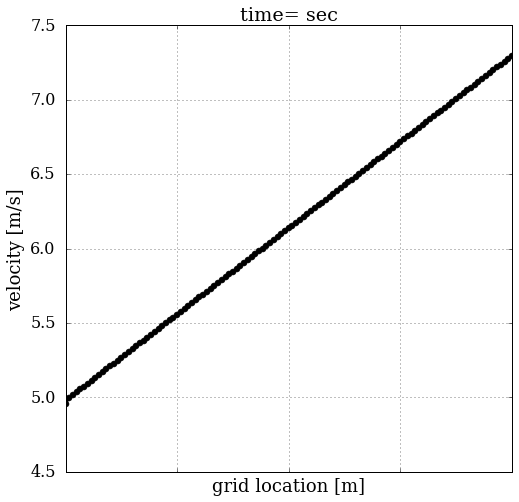

In [116]:
plot( xb,numpy.round(us[mid_time][1:-1], decimals=10), 'grid location [m]','velocity [m/s]',  'time= sec')

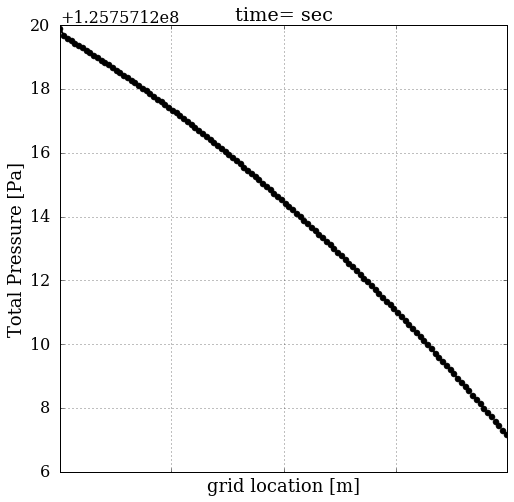

In [117]:
plot( xc,ps[mid_time][1:-1], 'grid location [m]','Total Pressure [Pa]',  'time= sec')

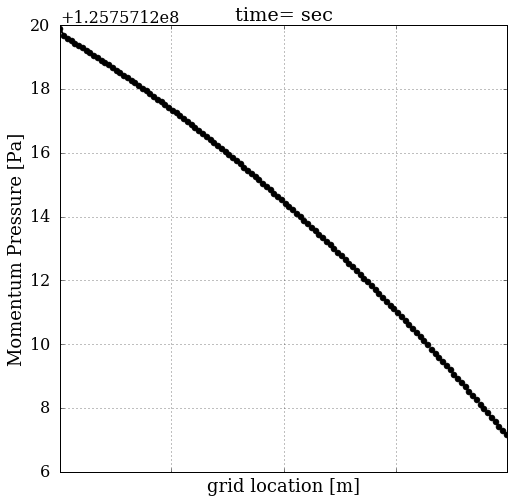

In [118]:
plot( xc,ps2[mid_time][1:-1], 'grid location [m]','Momentum Pressure [Pa]',  'time= sec')

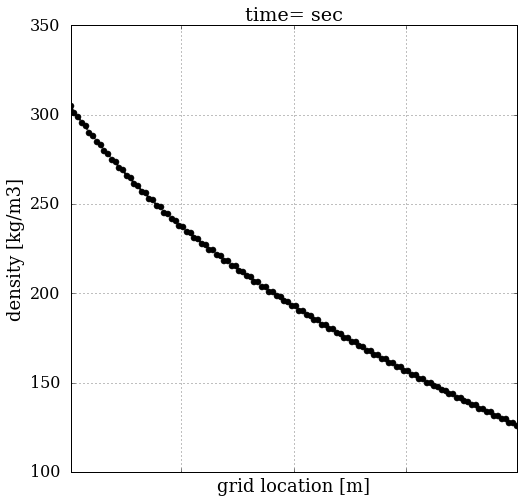

In [119]:
plot( xc,numpy.round(rhos[mid_time][1:-1],decimals=10), 'grid location [m]','density [kg/m3]',  'time= sec')

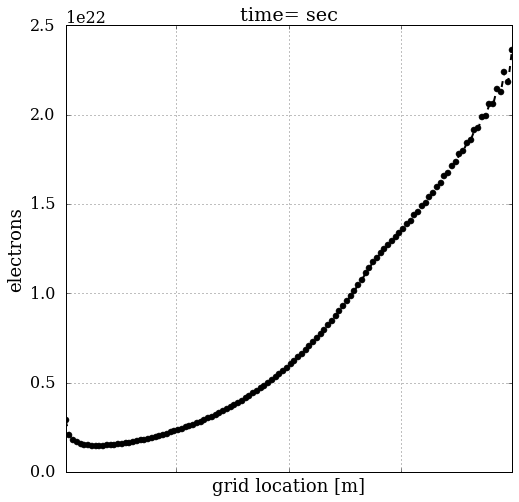

In [120]:
plot( xc,nes[mid_time][1:-1], 'grid location [m]','electrons',  'time= sec')

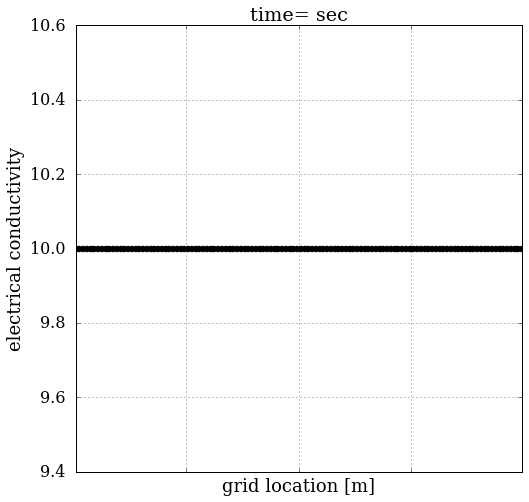

In [121]:
plot( xc,econds[mid_time][1:-1], 'grid location [m]','electrical conductivity',  'time= sec')

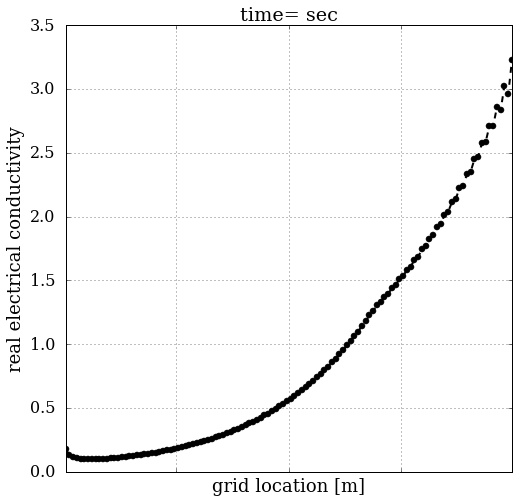

In [122]:
plot(xc,econdsreal[mid_time][1:-1], 'grid location [m]','real electrical conductivity',  'time= sec')

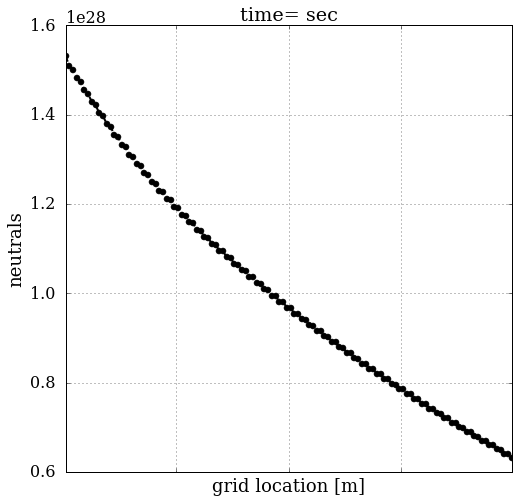

In [123]:
plot( xc, numpy.round(nos[mid_time][1:-1], decimals=25), 'grid location [m]','neutrals',  'time= sec')

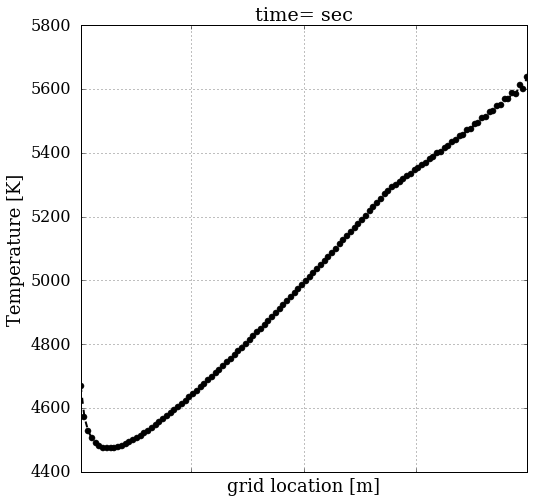

In [124]:
plot( xc,numpy.round(Ts[mid_time2][1:-1],decimals=10), 'grid location [m]','Temperature [K]',  'time= sec')

In [125]:
Ts[mid_time2]

array([ 5007.96750243,  4669.4047779 ,  4570.8733621 ,  4527.51962924,
        4504.74902407,  4490.32735407,  4481.21759348,  4475.94260287,
        4473.58460765,  4473.42904506,  4475.01981593,  4477.95604333,
        4482.01276036,  4486.94587313,  4492.64996163,  4498.95790023,
        4505.82882883,  4513.13427045,  4520.87205341,  4528.9334527 ,
        4537.34164879,  4545.99726994,  4554.94185366,  4564.07947911,
        4573.46616332,  4583.0057445 ,  4592.76638174,  4602.64916031,
        4612.73318007,  4622.9150349 ,  4633.28404675,  4643.73098122,
        4654.35506377,  4665.04016809,  4675.89541163,  4686.79683981,
        4697.86356642,  4708.96302212,  4720.22459451,  4731.5063321 ,
        4742.94829068,  4754.39837619,  4766.0077951 ,  4777.61361312,
        4789.37873576,  4801.12861598,  4813.03854105,  4824.92155174,
        4836.96606068,  4848.97186399,  4861.14132168,  4873.26006353,
        4885.54537141,  4897.76766041,  4910.16021399,  4922.47709795,
      

# final time

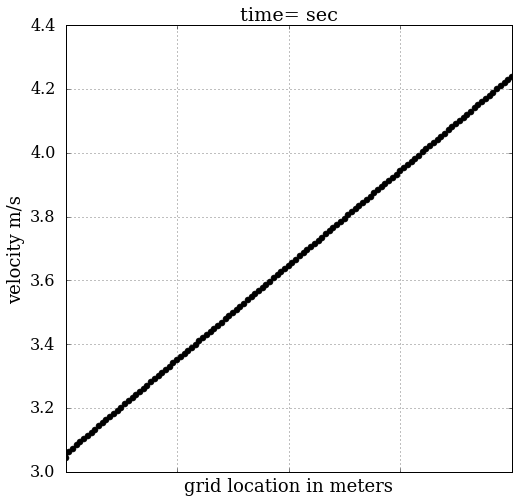

In [176]:
plot( xb,numpy.round(us[-1][1:-1],decimals=10), 'grid location in meters','velocity m/s',  'time= sec')

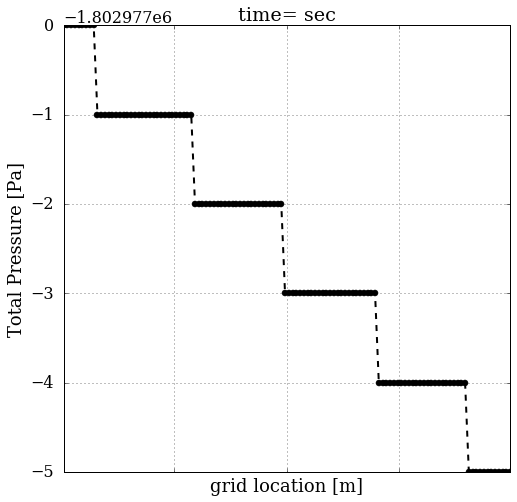

In [177]:
plot( xc,numpy.round(ps[-1][1:-1]), 'grid location [m]','Total Pressure [Pa]',  'time= sec')

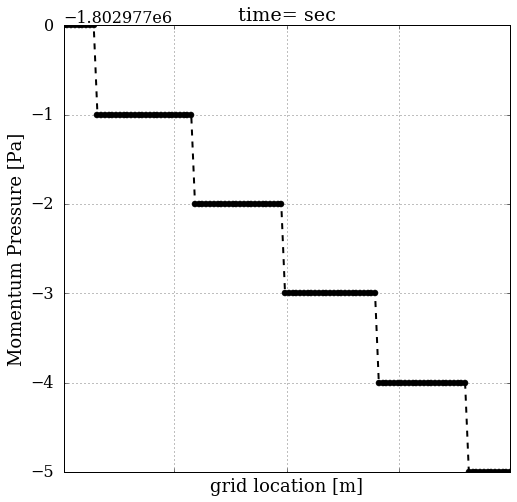

In [128]:
plot( xc,numpy.round(ps2[-1][1:-1]), 'grid location [m]','Momentum Pressure [Pa]',  'time= sec')

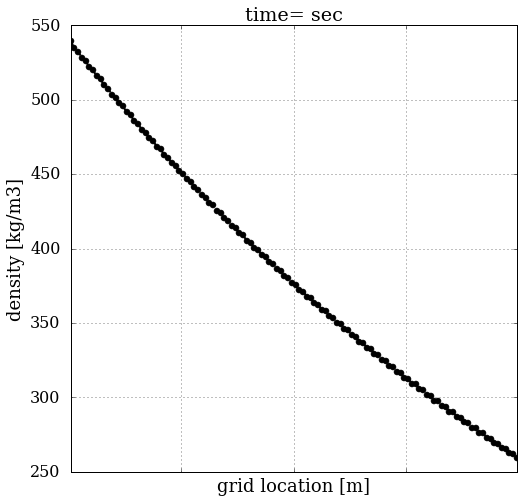

In [129]:
plot( xc,numpy.round(rhos[-1][1:-1], decimals=10), 'grid location [m]','density [kg/m3]',  'time= sec')

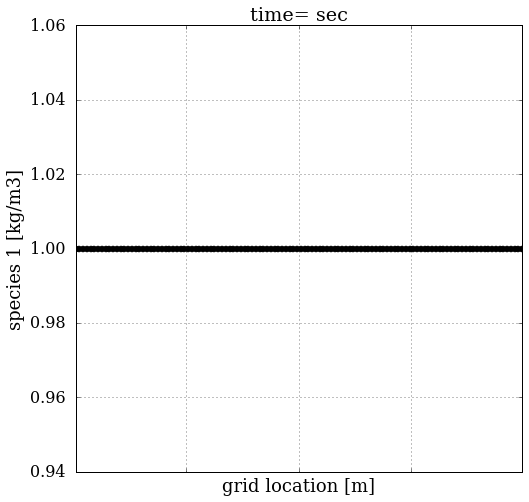

In [130]:
plot( xc,numpy.round(c1s[-1][1:-1], decimals=10), 'grid location [m]','species 1 [kg/m3]',  'time= sec')

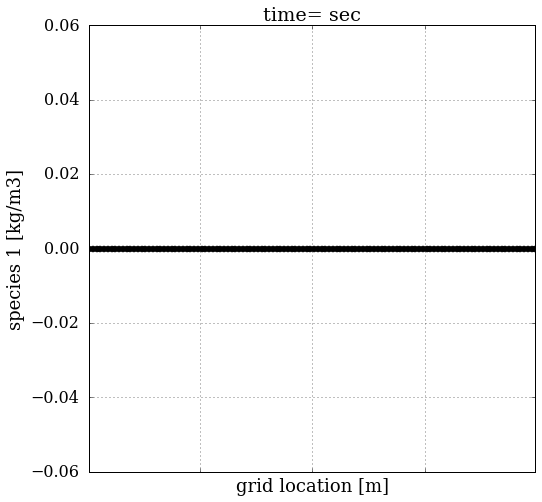

In [131]:
plot( xc,numpy.round(c2s[-1][1:-1], decimals=10), 'grid location [m]','species 1 [kg/m3]',  'time= sec')

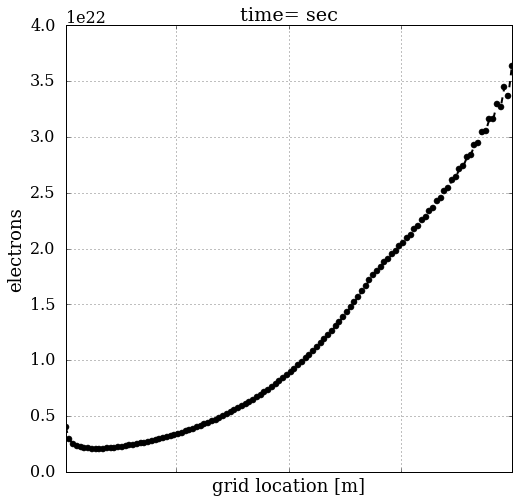

In [132]:
plot( xc,nes[-1][1:-1], 'grid location [m]','electrons',  'time= sec')

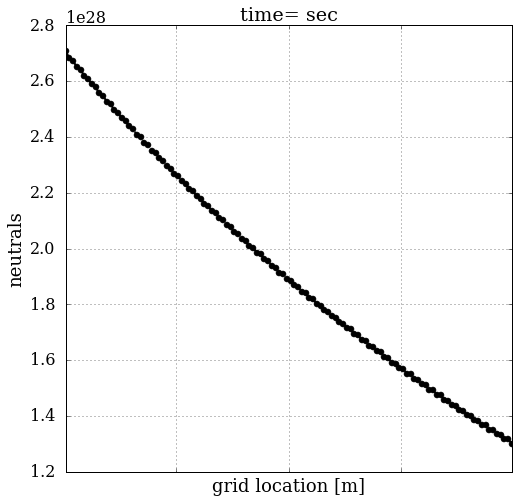

In [175]:
plot( xc, numpy.round(nos[-1][1:-1], decimals=25), 'grid location [m]','neutrals',  'time= sec')

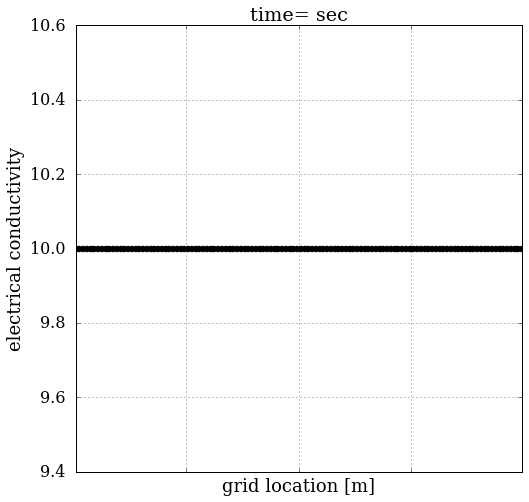

In [133]:
plot( xc,econds[-1][1:-1], 'grid location [m]','electrical conductivity',  'time= sec')

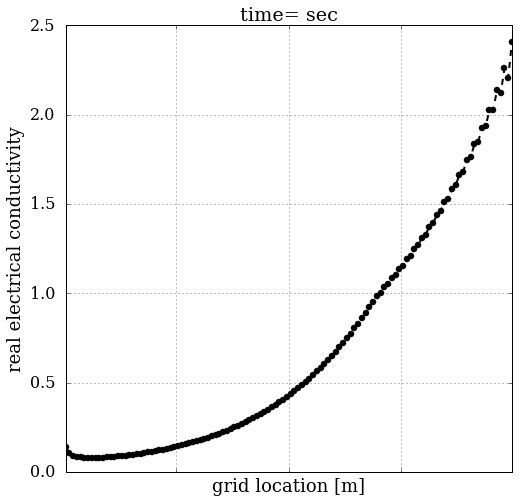

In [134]:
plot( xc,econdsreal[-1][1:-1], 'grid location [m]','real electrical conductivity',  'time= sec')

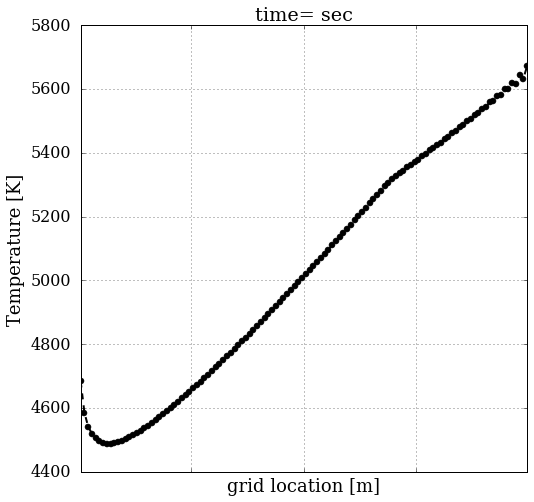

In [135]:
plot( xc,numpy.round(Ts[-1][1:-1],decimals=4), 'grid location [m]','Temperature [K]',  'time= sec')

### The graphs below address the issue of drastic variation in anode temperature. After some time, I noticed that  the anode temperature showed an usteady time dependency with oscillating values. To remedy, I chose to make the anode temperature the average of the domain when these variations begin to occur.

In [136]:
length = numpy.shape(ablrate)[0]
iterations_total = numpy.zeros((length))
Tanode = numpy.zeros((length))
#
for i in range(length):
    iterations_total[i] = i+1
    Tanode[i] = Ts[i][0]

In [137]:
numpy.shape(Ts)

(374852, 122)

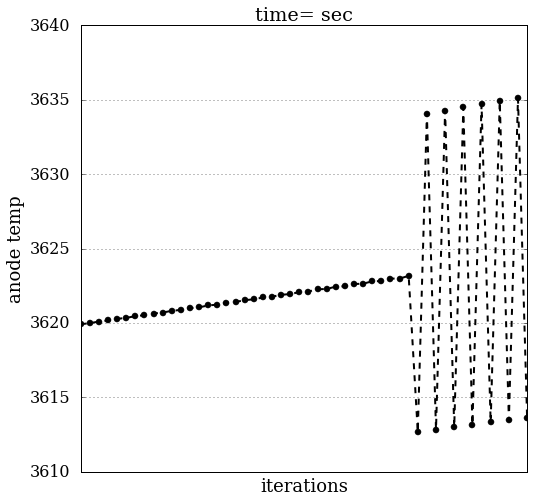

In [140]:
plot( iterations_total[1000:1050], numpy.round(Tanode[41100:41150],decimals=4), 'iterations','anode temp',  'time= sec')

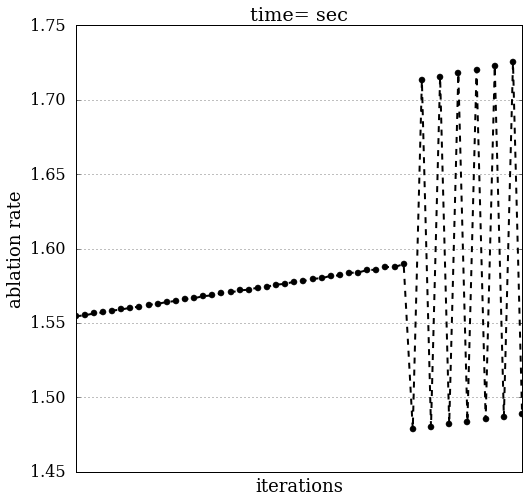

In [141]:
plot( iterations_total[1000:1050], numpy.round(ablrate[41100:41150],decimals=4), 'iterations','ablation rate',  'time= sec')

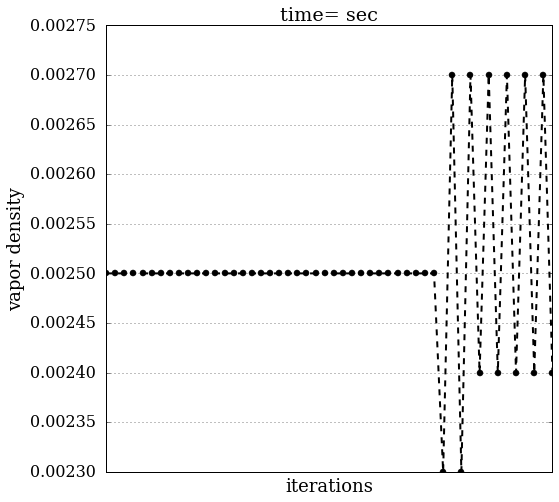

In [142]:
plot( iterations_total[1000:1050], numpy.round(rhos_vapor[41100:41150],decimals=4), 'iterations','vapor density',  'time= sec')

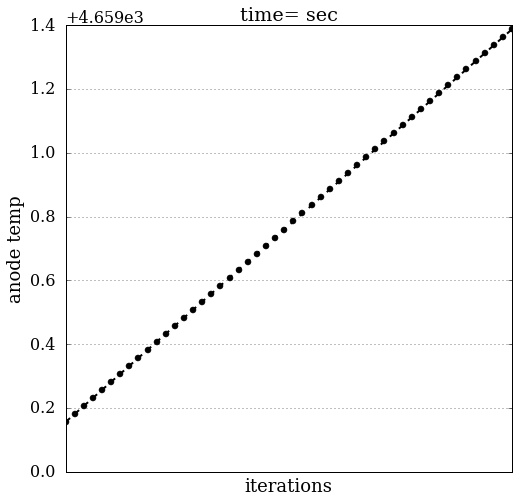

In [143]:
plot( iterations_total[1000:1050], numpy.round(Tanode[61100:61150],decimals=4), 'iterations','anode temp',  'time= sec')

### The anode temperature experiences a significant variation and i have minimized the noise by forcing the anode temperature to the average domain temperature whenever the temperature is lower than the previous anode temperature. This helps keep the ablation rate steady.

In [144]:
numpy.average(Ts[-1]-Ts[-2])

8.6502314522968833e-05

In [146]:
numpy.average(rhos[-1]-rhos[-2])

0.00091690874534636159

In [174]:
numpy.abs(numpy.average(us[-1]-us[-2]))

6.2890774306155508e-06

### After running the solver to 0.0015 seconds (real time), the average temperature change is 1.4e-4 Kelvin per time step. Additionally, the average mass change is 9.1e-4, and the average velocity change is 6.29 e -6.

### This may indicate that the solution is reaching steady state

## Animation

In [147]:
time_domain = numpy.size(ctime)
time_domain_temp = numpy.shape(Ts)[0] 
space_domain = numpy.size(xb)
space_domain2 = numpy.size(xc)
US = numpy.zeros((time_domain, space_domain), dtype=float)
TS = numpy.zeros((time_domain_temp, space_domain2), dtype=float)
JS = numpy.zeros((time_domain, space_domain2), dtype=float)
NES = numpy.zeros((time_domain, space_domain2), dtype=float)
RHOS = numpy.zeros((time_domain, space_domain2), dtype=float)
C1S = numpy.zeros((time_domain, space_domain2), dtype=float)
C2S = numpy.zeros((time_domain, space_domain2), dtype=float)
ECONDRS =  numpy.zeros((time_domain, space_domain2), dtype=float)
ECOND =  numpy.zeros((time_domain, space_domain2), dtype=float)
#
for i in range(time_domain):
    US[i,:] = us[i][1:-1]
#     JS[i,:] = js[i][1:-1]
    NES[i,:] = nes[i][1:-1]
    RHOS[i,:] = rhos[i][1:-1]
    ECONDRS[i,:] = econdsreal[i][1:-1]
    ECOND[i,:] = econds[i][1:-1]
    C1S[i,:] = c1s[i][1:-1]
    C2S[i,:] = c2s[i][1:-1]
    #
for i in range(time_domain_temp):
    TS[i,:] = Ts[i][1:-1]

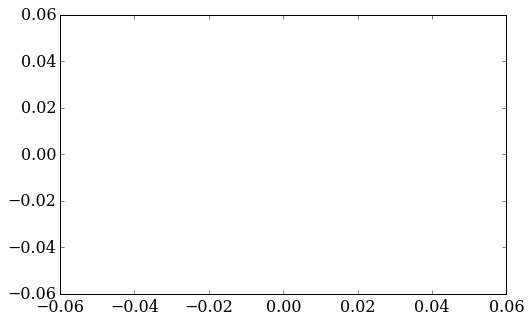

In [168]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes()
im = ax.plot([], [], color='b', ls='--', lw=3)

In [169]:
def animate(data):
    im = ax.plot(xb,data, color='b', ls='--', lw=3)
    return im

In [170]:
def animate2(data):
    im = ax.plot(xc,data, color='b', ls='--', lw=3)
    return im

In [171]:
anim = animation.FuncAnimation(fig, animate2, frames=ECOND[1::500,:], interval=200)

In [172]:
#anim.save("1D_ABL_rho.mp4", writer='ffmpeg')
#anim.save("1D_ABL_Ts.mp4", writer='ffmpeg')
#anim.save("1D_ABL_Us.mp4", writer='ffmpeg')
#anim.save("1D_ABL_NES.mp4", writer='ffmpeg')
#
anim.save("1D_ABL_econd.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c1.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c2.mp4", writer='ffmpeg')
#anim.save("1D_ABL_js.mp4", writer='ffmpeg')

In [ ]:
#display_animation(anim, default_mode='once')